In [1]:
import numpy as np
import pandas as pd
from scipy.stats import laplace, norm
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Logistic Ridge Regression Functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(beta, X, y, lambda_):
    logits = X @ beta
    log_likelihood = -np.mean(y * logits - np.log(1 + np.exp(logits))) * X.shape[0]
    ridge_penalty = 0.5 * lambda_ * np.sum(beta**2)
    return log_likelihood + ridge_penalty

def gradient(beta, X, y, lambda_):
    p = sigmoid(X @ beta)
    return -X.T @ (y - p) + lambda_ * beta

def hessian(beta, X, lambda_):
    p = sigmoid(X @ beta)
    W = np.diag(p * (1 - p))
    return X.T @ W @ X + lambda_ * np.eye(X.shape[1])

def newton_step(beta_init, X, y, lambda_, tol=1e-6, max_iter=100):
    beta = beta_init.copy()
    for step_count in range(1, max_iter + 1):
        grad = gradient(beta, X, y, lambda_)
        hess = hessian(beta, X, lambda_)
        step = np.linalg.solve(hess, grad)
        beta -= step
        if np.linalg.norm(step) < tol:
            return beta, step_count
    return beta, max_iter


# Set seed for reproducibility
np.random.seed(1)

# Parameters
n = 1800  # Fixed sample size
p = 2000  # Fixed number of features
MCMCsamples = 100
lambda_ = 1  # Regularization constant
# Generate data and fit model
m_max = 400
m_values = np.unique(np.logspace(0, np.log10(m_max), num=10, dtype=int))

# Initialize storage arrays
error_means_tilde = np.zeros(len(m_values))
error_stds_tilde = np.zeros(len(m_values))
error_means_tilde_2 = np.zeros(len(m_values))
error_stds_tilde_2 = np.zeros(len(m_values))
error_means_hat = np.zeros(len(m_values))
error_stds_hat = np.zeros(len(m_values))

for s in range(MCMCsamples):
    beta_star = np.random.normal(0, 1, p)
    X = np.random.normal(0, 1 / np.sqrt(n), (n, p))
    logits = X @ beta_star
    prob = sigmoid(logits)
    y = np.random.binomial(1, prob)

    beta_init = np.random.normal(0, 1, p) * 0.01
    # Compute Newton steps for beta_hat
    beta_hat, steps_used = newton_step(beta_init, X, y, lambda_)

    # Compute hat matrix H
    p_hat = sigmoid(X @ beta_hat)
    W = np.diag(p_hat * (1 - p_hat))
    hess_inv = np.linalg.inv(hessian(beta_hat, X, lambda_))
    H = X @ hess_inv @ X.T @ W
    tr_H = np.trace(H) / p
    print(f"---------------- s = {s}, df = {tr_H:.2f}, lambda = {lambda_}, n = {n}, p = {p}, Newton Steps: {steps_used} ----------------")

    errors_tilde, errors_tilde_2, errors_hat = [], [], []

    for m in m_values:
        iM = np.random.choice(n, size=m, replace=False)
        X_M, y_M = X[iM], y[iM]
        iMc = np.setdiff1d(np.arange(n), iM)
        X_Mc, y_Mc = X[iMc], y[iMc]

        beta_init = np.random.normal(0, 1, p) * 0.01
        beta_hat_M_out, steps_used = newton_step(beta_init, X_Mc, y_Mc, lambda_)

        # Compute beta_tilde_m_out
        diag_l_M = np.diag(p_hat[iM] * (1 - p_hat[iM]))
        E_M = hess_inv @ X_M.T
        H_M = diag_l_M @ X_M @ E_M
        l_dot_M = p_hat[iM] - y_M
        beta_tilde_m_out = beta_hat + E_M @ np.linalg.inv(np.eye(m) - H_M) @ l_dot_M

        # Compute beta_tilde_m_out_2
        hess_Mc_tilde = hessian(beta_tilde_m_out, X_Mc, lambda_)
        grad_Mc_tilde = gradient(beta_tilde_m_out, X_Mc, y_Mc, lambda_)
        beta_tilde_m_out_2 = beta_tilde_m_out - np.linalg.solve(hess_Mc_tilde, grad_Mc_tilde)

        # Compute errors
        errors_tilde.append(np.linalg.norm(beta_hat_M_out - beta_tilde_m_out))
        errors_tilde_2.append(np.linalg.norm(beta_hat_M_out - beta_tilde_m_out_2))
        errors_hat.append(np.linalg.norm(beta_hat_M_out - beta_hat))

        # Linear regression log(error) vs log(m)
        if len(errors_tilde) > 2:
          log_m = np.log(m_values[:len(errors_tilde)])
          X_reg = sm.add_constant(log_m)
          def fit_model(errors):
            return sm.OLS(np.log(errors), X_reg).fit()
          models = {
                "tilde": fit_model(errors_tilde),
                "tilde_2": fit_model(errors_tilde_2),
                "hat": fit_model(errors_hat),
          }
          results = {
                name: {
                    "slope": model.params[1],
                    "conf_int": model.conf_int()[1],
                    "R2": model.rsquared,
                }
                for name, model in models.items()
          }
          print(f"    m = {m:>4d}: "
              f"|b_tilde_M - b_hat_M| = {errors_tilde[-1]:.2f}, slope = {results['tilde']['slope']:.2f}, "
              f"CI = ({results['tilde']['conf_int'][0]:6.2f}, {results['tilde']['conf_int'][1]:6.2f}), R² = {results['tilde']['R2']:.2f} | "
              f"|b_tilde_M_2 - b_hat_M| = {errors_tilde_2[-1]:.2f}, slope = {results['tilde_2']['slope']:.2f}, "
              f"CI = ({results['tilde_2']['conf_int'][0]:6.2f}, {results['tilde_2']['conf_int'][1]:6.2f}), R² = {results['tilde_2']['R2']:.2f} | "
              f"|b_hat - b_hat_M| = {errors_hat[-1]:.1f}, slope = {results['hat']['slope']:.2f}, "
              f"CI = ({results['hat']['conf_int'][0]:6.2f}, {results['hat']['conf_int'][1]:6.2f}), R² = {results['hat']['R2']:.2f} |")



    # Incremental mean update
    delta = np.array(errors_tilde) - error_means_tilde
    error_means_tilde += delta / (s + 1)

    # Incremental variance update (Welford’s method)
    error_stds_tilde = np.sqrt((s * error_stds_tilde**2 + delta * (np.array(errors_tilde) - error_means_tilde)) / (s + 1))

    # Repeat for tilde_2 and hat variables
    delta_2 = np.array(errors_tilde_2) - error_means_tilde_2
    error_means_tilde_2 += delta_2 / (s + 1)
    error_stds_tilde_2 = np.sqrt((s * error_stds_tilde_2**2 + delta_2 * (np.array(errors_tilde_2) - error_means_tilde_2)) / (s + 1))

    delta_hat = np.array(errors_hat) - error_means_hat
    error_means_hat += delta_hat / (s + 1)
    error_stds_hat = np.sqrt((s * error_stds_hat**2 + delta_hat * (np.array(errors_hat) - error_means_hat)) / (s + 1))


    # Print final results
    error_table = pd.DataFrame({
      'm': m_values,
      'Mean Error Tilde': np.round(error_means_tilde, 3),
      'SD Tilde': np.round(error_stds_tilde, 3),
      'Mean Error Tilde_2': np.round(error_means_tilde_2, 3),
      'SD Tilde_2': np.round(error_stds_tilde_2, 3),
      'Mean Error Hat': np.round(error_means_hat, 3),
      'SD Hat': np.round(error_stds_hat, 3)
      })

    print(error_table.to_string(index=False))




---------------- s = 0, df = 0.16, lambda = 1, n = 1800, p = 2000, Newton Steps: 4 ----------------
    m =    7: |b_tilde_M - b_hat_M| = 0.00, slope = 1.19, CI = ( -1.04,   3.42), R² = 0.98 | |b_tilde_M_2 - b_hat_M| = 0.00, slope = 2.32, CI = ( -1.25,   5.89), R² = 0.99 | |b_hat - b_hat_M| = 0.9, slope = 0.61, CI = ( -0.72,   1.95), R² = 0.97 |
    m =   14: |b_tilde_M - b_hat_M| = 0.00, slope = 1.20, CI = (  0.82,   1.57), R² = 0.99 | |b_tilde_M_2 - b_hat_M| = 0.00, slope = 2.38, CI = (  1.76,   2.99), R² = 0.99 | |b_hat - b_hat_M| = 1.5, slope = 0.60, CI = (  0.38,   0.83), R² = 0.99 |
    m =   27: |b_tilde_M - b_hat_M| = 0.00, slope = 1.11, CI = (  0.86,   1.36), R² = 0.99 | |b_tilde_M_2 - b_hat_M| = 0.00, slope = 2.22, CI = (  1.79,   2.66), R² = 0.99 | |b_hat - b_hat_M| = 1.7, slope = 0.55, CI = (  0.39,   0.71), R² = 0.98 |
    m =   54: |b_tilde_M - b_hat_M| = 0.01, slope = 1.10, CI = (  0.94,   1.25), R² = 0.99 | |b_tilde_M_2 - b_hat_M| = 0.00, slope = 2.24, CI = (  1.98,   2

In [7]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for clean tabular output including tilde, tilde_2, and hat errors
error_table = pd.DataFrame({
    'm': m_values,
    'Mean Error Tilde': np.round(error_means_tilde, 3),
    'SD Tilde': np.round(error_stds_tilde, 3),
    'Mean Error Tilde_2': np.round(error_means_tilde_2, 3),
    'SD Tilde_2': np.round(error_stds_tilde_2, 3),
    'Mean Error Hat': np.round(error_means_hat, 3),
    'SD Hat': np.round(error_stds_hat, 3)
})

# Print the table in a readable format
print(error_table.to_string(index=False))

# Log-transformed error means for tilde, tilde_2, and hat
log_error_means_tilde = np.log(error_means_tilde)
log_error_means_tilde_2 = np.log(error_means_tilde_2)
log_error_means_hat = np.log(error_means_hat)

# Linear regression models with weights (considering standard deviations)
X_reg = sm.add_constant(np.log(m_values))

model_tilde = sm.WLS(log_error_means_tilde, X_reg).fit()
model_tilde_2 = sm.WLS(log_error_means_tilde_2, X_reg).fit()
model_hat = sm.WLS(log_error_means_hat, X_reg).fit()

# Extract parameters for tilde, tilde_2, and hat
slope_tilde = model_tilde.params[1]
conf_int_tilde = model_tilde.conf_int()[1]
R2_tilde = model_tilde.rsquared

slope_tilde_2 = model_tilde_2.params[1]
conf_int_tilde_2 = model_tilde_2.conf_int()[1]
R2_tilde_2 = model_tilde_2.rsquared

slope_hat = model_hat.params[1]
conf_int_hat = model_hat.conf_int()[1]
R2_hat = model_hat.rsquared

# Predictions for regression lines
log_error_pred_tilde = model_tilde.predict(X_reg)
log_error_pred_tilde_2 = model_tilde_2.predict(X_reg)
log_error_pred_hat = model_hat.predict(X_reg)


  m  Mean Error Tilde  SD Tilde  Mean Error Tilde_2  SD Tilde_2  Mean Error Hat  SD Hat
  1             0.000     0.000                 0.0         0.0           0.364   0.063
  3             0.000     0.000                 0.0         0.0           0.621   0.060
  7             0.001     0.000                 0.0         0.0           0.960   0.076
 14             0.001     0.000                 0.0         0.0           1.360   0.073
 27             0.002     0.000                 0.0         0.0           1.873   0.067
 54             0.005     0.000                 0.0         0.0           2.663   0.074
105             0.009     0.001                 0.0         0.0           3.703   0.078
205             0.017     0.001                 0.0         0.0           5.208   0.090
400             0.032     0.002                 0.0         0.0           7.332   0.098


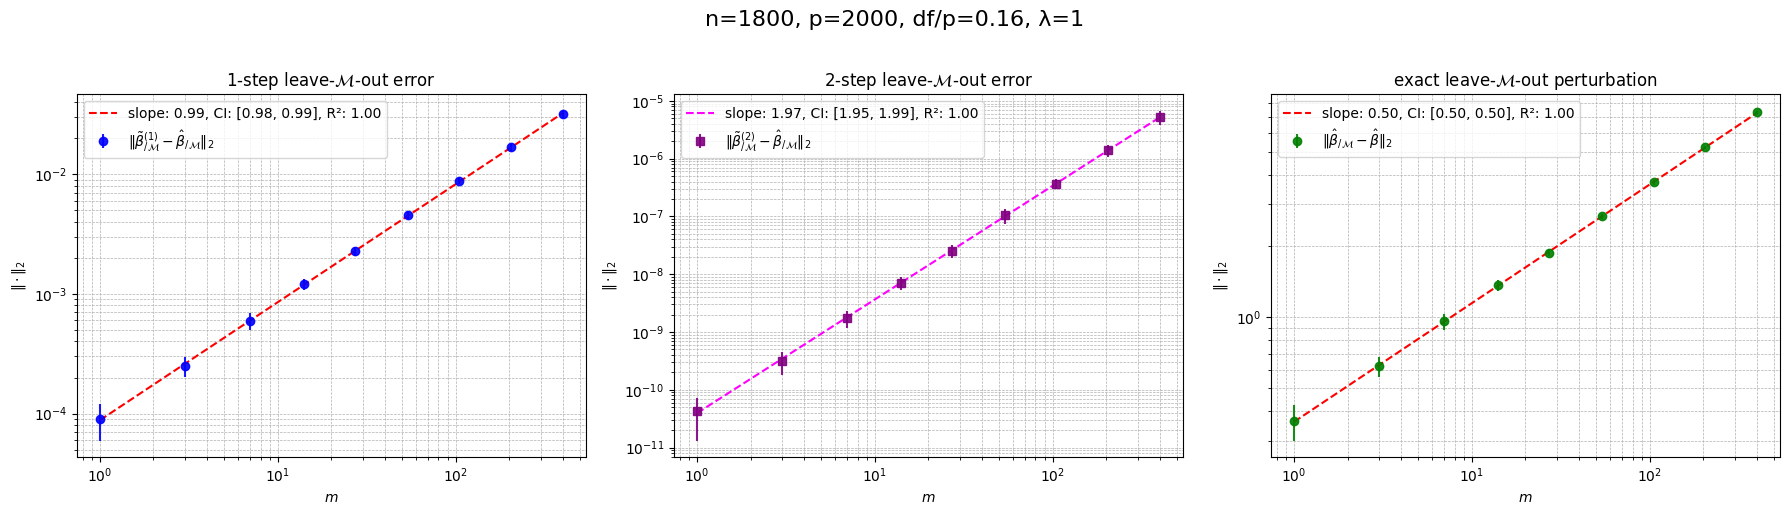

In [10]:
# Create a 1x3 panel plot with true log-log scale and error bars
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Titles including parameters
title_text = f"n={n}, p={p}, df/p={tr_H:.2f}, λ={lambda_}"

# ---- Panel 1: One Newton Step Error (Tilde) ----
axes[0].errorbar(m_values, error_means_tilde, yerr=error_stds_tilde, fmt='o',
                 color='blue', alpha=0.9, label=r'$\|\tilde{\beta}^{(1)}_{/ \mathcal{M}} - \hat{\beta}_{/ \mathcal{M}}\|_2$')
axes[0].plot(m_values, np.exp(log_error_pred_tilde),
             label=f'slope: {slope_tilde:.2f}, CI: [{conf_int_tilde[0]:.2f}, {conf_int_tilde[1]:.2f}], R²: {R2_tilde:.2f}',
             color='red', linestyle='--')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel(r'$m$')
axes[0].set_ylabel(r'$\|\cdot\|_2$')
axes[0].set_title(r'1-step leave-$\mathcal{M}$-out error')# + "\n" + title_text)
axes[0].legend()
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# ---- Panel 2: Two Newton Step Error (Tilde_2) ----
axes[1].errorbar(m_values, error_means_tilde_2, yerr=error_stds_tilde_2, fmt='s',
                 color='purple', alpha=0.9, label=r'$\|\tilde{\beta}^{(2)}_{/ \mathcal{M}} - \hat{\beta}_{/ \mathcal{M}}\|_2$')
axes[1].plot(m_values, np.exp(log_error_pred_tilde_2),
             label=f'slope: {slope_tilde_2:.2f}, CI: [{conf_int_tilde_2[0]:.2f}, {conf_int_tilde_2[1]:.2f}], R²: {R2_tilde_2:.2f}',
             color='magenta', linestyle='--')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel(r'$m$')
axes[1].set_ylabel(r'$\|\cdot\|_2$')
axes[1].set_title(r'2-step leave-$\mathcal{M}$-out error')# + "\n" + title_text)
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# ---- Panel 3: Leave-M-out Perturbation (Hat) ----
axes[2].errorbar(m_values, error_means_hat, yerr=error_stds_hat, fmt='o',
                 color='green', alpha=0.9, label=r'$\|\hat{\beta}_{/ \mathcal{M}} - \hat{\beta}\|_2$')
axes[2].plot(m_values, np.exp(log_error_pred_hat),
             label=f'slope: {slope_hat:.2f}, CI: [{conf_int_hat[0]:.2f}, {conf_int_hat[1]:.2f}], R²: {R2_hat:.2f}',
             color='red', linestyle='--')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_xlabel(r'$m$')
axes[2].set_ylabel(r'$\|\cdot\|_2$')
axes[2].set_title(r'exact leave-$\mathcal{M}$-out perturbation')# + "\n" + title_text)
axes[2].legend()
axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)
fig.suptitle(title_text, fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
#np.savetxt("linear-noncons/elnet/lo_delta0_5p200.csv", lo, delimiter=",")
#np.savetxt("linear-noncons/elnet/outErr_delta0_5p200.csv", outErr, delimiter=",")